<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

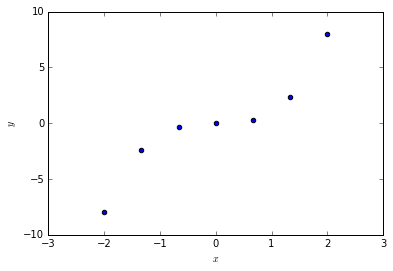

In [162]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

In [19]:
# будет константа 0

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [163]:
x0 = list(filter(lambda x: x<0, X))
x1 = list(filter(lambda x: x>=0, X))
x0,x1

([-2.0, -1.3333333333333335, -0.66666666666666674],
 [0.0, 0.66666666666666652, 1.333333333333333, 2.0])

In [164]:
def f(x):
    return x ** 3

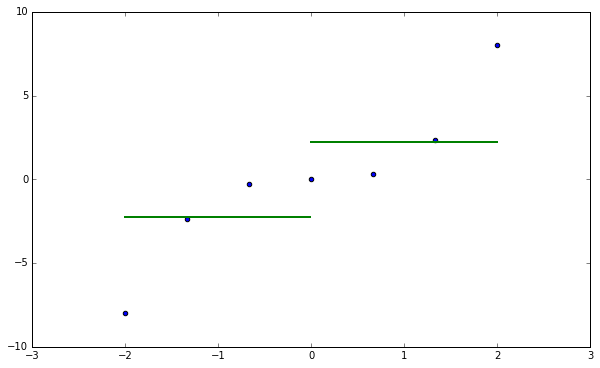

In [165]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c="b", s=20)
n_dots = 10

plt.plot(np.linspace(-2,-0.01,n_dots), [np.mean(f(np.linspace(-2,-0.01,n_dots))) for i in range(n_dots)], "g", lw=2)
plt.plot(np.linspace(0,2,n_dots), [np.mean(f(np.linspace(0,2,n_dots))) for i in range(n_dots)], "g", lw=2)
#plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [166]:
def regression_var_criterion(X, y, t):
    Xl = np.array(list(filter(lambda x: x<t, X)))
    Xr = np.array(list(filter(lambda x: x>=t, X)))
    return np.var(y) - len(Xl)/len(X)*np.var(f(Xl)) - len(Xr)/len(X)*np.var(f(Xr))

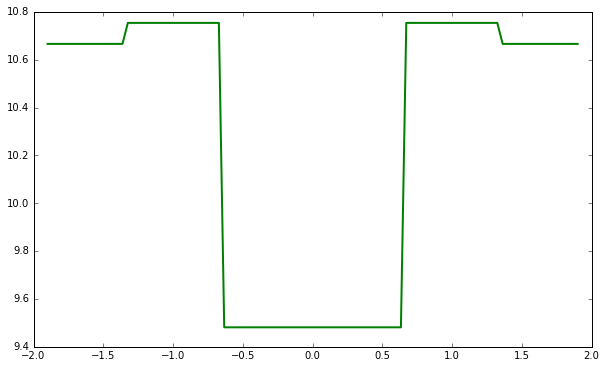

In [167]:
plt.figure(figsize=(10, 6))
n_dots = 100
l = np.linspace(-1.9,1.9,n_dots)
plt.plot(l, [regression_var_criterion(X, y, l_) for l_ in l], "g", lw=2)
#plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

In [56]:
# нет

In [168]:
reg_tree = DecisionTreeRegressor(max_depth=1, random_state=17)
reg_tree.fit(X.reshape(-1,1), y)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')

In [170]:
export_graphviz(reg_tree, 
out_file='../../img/hw2_q1.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng '../../img/hw2_q1.dot' -o '../../img/hw2_q1.png'

<img src = '../../img/hw2_q1.png'>

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [171]:
x0_l = list(filter(lambda x: x<-1.5, x0))
x0_r = list(filter(lambda x: x>=-1.5, x0))
x1_l = list(filter(lambda x: x<1.5, x1))
x1_r = list(filter(lambda x: x>=1.5, x1))

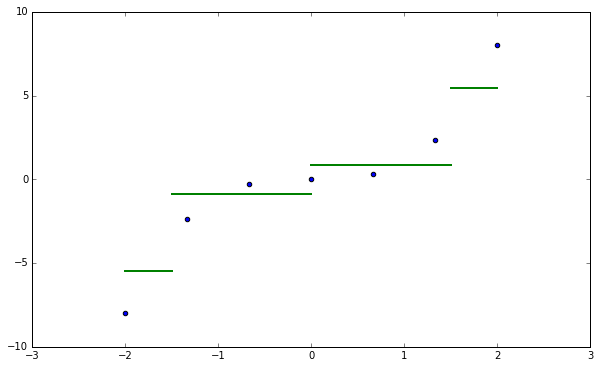

In [172]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c="b", s=20)
n_dots = 100
plt.plot(np.linspace(-2,-1.5,n_dots), [np.mean(f(np.linspace(-2,-1.5,n_dots))) for i in range(n_dots)], "g", lw=2)
plt.plot(np.linspace(-1.5,0,n_dots), [np.mean(f(np.linspace(-1.5,0,n_dots))) for i in range(n_dots)], "g", lw=2)
plt.plot(np.linspace(0,1.5,n_dots), [np.mean(f(np.linspace(0,1.5,n_dots))) for i in range(n_dots)], "g", lw=2)
plt.plot(np.linspace(1.5,2,n_dots), [np.mean(f(np.linspace(1.5,2,n_dots))) for i in range(n_dots)], "g", lw=2)

#plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

In [82]:
# 7 ?

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [173]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [174]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [175]:
df['age_years'] = np.round(df['age']/365.25)

In [176]:
df = pd.concat([df, 
                pd.get_dummies(df['cholesterol'], prefix="cholesterol"),
                pd.get_dummies(df['gluc'], prefix="gluc")
               ],
                     axis=1)

In [177]:
y = df['cardio']
df.drop(['cardio', 'age', 'cholesterol', 'gluc'], axis=1, inplace=True)

In [178]:
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,156,85.0,140,90,0,0,1,55.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,165,64.0,130,70,0,0,0,52.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2,169,82.0,150,100,0,0,1,48.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,156,56.0,100,60,0,0,0,48.0,1.0,0.0,0.0,1.0,0.0,0.0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [179]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3, random_state=17)

In [180]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((49000, 15), (21000, 15), (49000,), (21000,))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [181]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17) # criterion='entropy', 
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [182]:
export_graphviz(clf_tree, feature_names=(df.columns), 
out_file='../../img/hw2_q2.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng '../../img/hw2_q2.dot' -o '../../img/hw2_q2.png'

<img src="../../img/hw2_q2.png">

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

In [183]:
#age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [185]:
tree_pred = clf_tree.predict(X_valid)

In [186]:
accuracy_score(y_valid, tree_pred)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [189]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

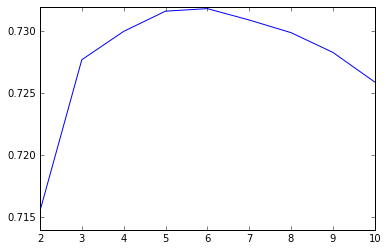

In [204]:
plt.plot(list(range(2, 11)),tree_grid.cv_results_['mean_test_score'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [191]:
tree_grid.best_params_

{'max_depth': 6}

In [192]:
tree_grid.best_score_ # лучший score на CV-выборке

0.73183673469387756

In [212]:
accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid)) # score "лучшего" дерева на тестовой выборке

0.7264761904761905

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

In [213]:
# 1) да

In [215]:
# 2) нет
(accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid)) - accuracy_score(y_valid, tree_pred))*100

0.51904761904761898

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [228]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', index_col='id', sep=';')

In [229]:
df['age_years'] = np.round(df['age']/365.25)

In [230]:
df = pd.concat([df, 
                pd.get_dummies(df['cholesterol'], prefix="cholesterol"),
               ],
                     axis=1)

In [231]:
df['age_45'] = df['age_years'].apply(lambda a: int((a>=45) and (a<50)))
df['age_50'] = df['age_years'].apply(lambda a: int((a>=50) and (a<55)))
df['age_55'] = df['age_years'].apply(lambda a: int((a>=55) and (a<60)))
df['age_60'] = df['age_years'].apply(lambda a: int((a>=60) and (a<65)))

In [232]:
df['ap_hi_120'] = df['ap_hi'].apply(lambda a: int((a>=120) and (a<140)))
df['ap_hi_140'] = df['ap_hi'].apply(lambda a: int((a>=140) and (a<160)))
df['ap_hi_160'] = df['ap_hi'].apply(lambda a: int((a>=160) and (a<180)))

In [233]:
df['male'] = df['gender'].apply(lambda g: 1 if g==2 else 0)

In [234]:
df[[
    'age_45', 'age_50', 'age_55', 'age_60', 
    'ap_hi_120', 'ap_hi_140', 'ap_hi_160', 
    'male', 
    'smoke',
    'cholesterol_1', 'cholesterol_2', 'cholesterol_3']].head()

,age_45,age_50,age_55,age_60,ap_hi_120,ap_hi_140,ap_hi_160,male,smoke,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,0,1.0,0.0,0.0
1,0,0,1,0,0,1,0,0,0,0.0,0.0,1.0
2,0,1,0,0,1,0,0,0,0,0.0,0.0,1.0
3,1,0,0,0,0,1,0,1,0,1.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0


In [227]:
tree5 = DecisionTreeClassifier(max_depth=3, random_state=17)

In [235]:
tree5.fit(
    df[[
    'age_45', 'age_50', 'age_55', 'age_60', 
    'ap_hi_120', 'ap_hi_140', 'ap_hi_160', 
    'male', 
    'smoke',
    'cholesterol_1', 'cholesterol_2', 'cholesterol_3'
    ]],
    df['cardio']
         )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [237]:
export_graphviz(tree5, feature_names=[
    'age_45', 'age_50', 'age_55', 'age_60', 
    'ap_hi_120', 'ap_hi_140', 'ap_hi_160', 
    'male', 
    'smoke',
    'cholesterol_1', 'cholesterol_2', 'cholesterol_3'
    ], 
out_file='../../img/hw2_q5.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng '../../img/hw2_q5.dot' -o '../../img/hw2_q5.png'

<img src='../../img/hw2_q5.png'>

In [238]:
#Верхнее артериальное давление от 140 до 160 (мм рт.ст.)